# Check to see if we're running in Colab (versus local server)

In [1]:
try:
    from google.colab import drive

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print("We're running Colab")

# Mount the Google Drive (if we're in Colab), switch current directory to a directory on the Google Drive
- we will (optionally) create the specified directory on the Google Drive if it doesn't exist

- navigate to our Harvard Capstone shared folder -> right-click -> organize -> add shortcut -> all locations -> add "My Drive"

In [2]:
if IN_COLAB:
    # Mount the Google Drive at mount
    mount = "/content/gdrive"
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    import os

    drive_root = mount + "/My Drive/Harvard Capstone/Modeling/UNet"

    # Create drive_root if it doesn't exist
    # create_drive_root = True
    # if create_drive_root:
    #  print("\nColab: making sure ", drive_root, " exists.")
    #  os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root

# Work with files on the Google Drive
- existing files
- upload files to Google Drive (as per normal)
- load files from external source

In [3]:
# Verify we're in the correct working directory
%pwd

'/home/bacon/code/personal/icedyno/unet_model'

## Verify that imports (of modules on the Google Drive) work

In [4]:
import glob, json, os
import datetime as dt
from IPython.display import HTML

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Conv2DTranspose,
    concatenate,
    Input,
    Lambda,
    Activation,
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    Input,
    Lambda,
    Activation,
    Add,
    Reshape,
)
from tensorflow.keras.models import Model

In [5]:
data_root = "ims_netcdf_1km_cropped_2_000km_window_74lat_-170lon/"
if not IN_COLAB:
    data_root = os.path.join("..", "data", data_root)
    tf.config.set_visible_devices([], "GPU")
WINDOW_SIZE = 2000  # km

2024-03-23 12:35:41.844238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-23 12:35:41.887384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-23 12:35:41.887706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Data Processing: XArray and Numpy


In [6]:
# Define a function to load a single .nc file for a given year and day
def load_nc_file(year, day) -> xr.Dataset:
    """Loads the cropped, grid-corrected netcdf files on the Beaufort Sea with 74,0lat_-170,0lon"""
    # Generate the file path based on the year and day
    file_path = os.path.join(
        data_root,
        str(year),
        f"ims{year}{day:03d}_1km_v1.3_grid{WINDOW_SIZE}_74,0lat_-170,0lon.nc",
    )

    # Load the .nc file using xarray
    with xr.open_dataset(file_path) as dataset:
        return dataset

In [7]:
def crop_to_beaufort_sea(ds: xr.Dataset, window_size: int) -> xr.Dataset:
    """
    Center window on beaufort sea coordinates in **current** netcdf coordinate system (not quite polar stereographic) and
    crop to WINDOW_SIZE x WINDOW_SIZE (not 2*window size x 2*window size as was previously)
    """
    # Beaufort Sea x, y in **current** IMS netcdf coordinate system
    x = -1652603.364653003  # meters
    y = -291398.56159791426  # meters

    # These x, y in convert back to the below with current geolocation.py functions.
    ## longitude: -80.0, latitude: 74.0
    # Actual Beaufort Sea coordinates are closer to longitude: -140, latitude: 74.

    beaufort_ds = ds.sel(
        x=slice(x - 1000 * window_size // 2, x + 1000 * window_size // 2),
        y=slice(y - 1000 * window_size // 2, y + 1000 * window_size // 2),
    )
    return beaufort_ds

In [8]:
def load_sie_data(year, day) -> np.array:
    """Returns a 2D numpy array copy of the IMS surface values"""
    return load_nc_file(year, day).IMS_Surface_Values[0].values.copy()

In [9]:
def load_target_sie_data(year, day) -> np.array:
    """Returns a 2D numpy array copy of the IMS surface values"""
    ds = load_nc_file(year, day)
    sie = ds.IMS_Surface_Values[0].values.copy()
    binary_sie = sie.copy()
    binary_sie[sie != 3] = 0

    # Sea and Lake Ice is treated as 1
    binary_sie[sie == 3] = 1
    return binary_sie

In [10]:
def binarize_data(sie: np.array) -> np.array:
    """
    New SIE:
    0: Open water/out of bounds
    1: Sea ice or lake ice (lake mask not applied)
    2: Land
    """
    binary_sie = sie.copy()
    binary_sie[sie != 3] = 0

    # Sea and Lake Ice is treated as 1
    binary_sie[sie == 3] = 1

    # Land and Snow-Covered Land is sent to 2.
    binary_sie[sie == 2] = 2
    binary_sie[sie == 4] = 2
    return binary_sie

In [11]:
def load_n_day_chunk(year: int, day: int, n=4) -> np.array:
    """
    Return np.array with shape (height, width, channels).

    Does NOT wrap years or account for missing days.
    Starts n_day chunk at specified day, year.

    Returns:
        np.array: shape (sie_y_shape, sie_x_shape, n_day)
    """
    sie_chunk = []
    for day in range(day, day + n):
        sie = binarize_data(load_sie_data(year, day))
        sie_chunk.append(sie)

    assert len(sie_chunk) == n
    # Use np.stack to stack the individual 2D arrays along a new third axis, resulting in (height, width, channels)
    return np.stack(sie_chunk, axis=-1)

## Example usage

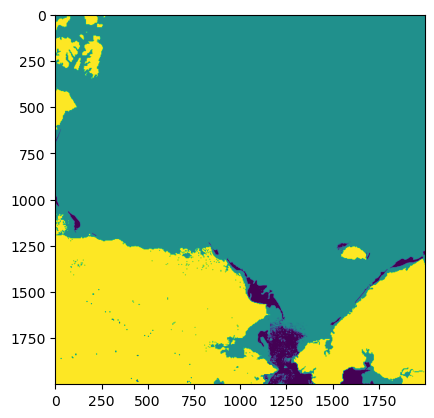

In [12]:
# Example usage:
example = True
if example:
    year = 2023
    day = 150
    data = load_nc_file(year, day)
    multiclass_sie = load_sie_data(year, day)
    sie = binarize_data(multiclass_sie)
    plt.imshow(sie)

# Data Processing: Loading data for Tensorflow

# Data generator for all data available
To be used as either train or test data generator, depending on slice of filenames passed in.

In [13]:
class AllDataGenerator(tf.keras.utils.Sequence):
    """
    Generator for Keras training to allow multiprocessing and training on batches with only the
    batch itself being loaded into memory.

    """

    def __init__(
        self,
        filenames: list[str],
        batch_size: int = 2,
        dim: tuple = (8000, 8000, 5),
        shuffle: bool = True,
    ):
        self.filenames = sorted(filenames)
        self.years = self.years_from_filenames()
        self.days = self.days_from_filenames()
        self.batch_size = batch_size
        self.dim = dim  # (height, width, channel)
        self.shuffle = True
        self.data_IDs = self._get_data_ids()
        self.on_epoch_end()

    def years_from_filenames(self):
        years = [
            int(file.split("/")[-1].split("ims")[1][:4]) for file in self.filenames
        ]
        return years

    def days_from_filenames(self):
        days = [int(file.split("/")[-1].split("_")[0][-3:]) for file in self.filenames]
        return days

    def _get_data_ids(self):
        return list(zip(self.years, self.days))

    def get_years_days_of_batch(self, index: int):
        """Given a batch index, return a list of the year and days for that batch"""
        years = self.years[index * self.batch_size : (index + 1) * self.batch_size]
        days = self.days[index * self.batch_size : (index + 1) * self.batch_size]
        return list(zip(years, days))

    def __len__(self):
        """Number of batches per epoch"""
        return len(self.data_IDs) // self.batch_size

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Collect data IDs for this batch number
        batch_data_ids = self.data_IDs[
            index * self.batch_size : (index + 1) * self.batch_size
        ]

        # Generate data
        X, y = self._data_generation(batch_data_ids)

        return X.astype("float16"), y.astype("int32")

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.data_IDs)

    def load_n_day_chunk(self, i, n):
        """Starts at year, day and returns the next n days of processed SIE."""
        days = self.days[i : i + n]
        years = self.years[i : i + n]

        sie_chunk = []
        for year, day in zip(years, days):
            sie = binarize_data(load_sie_data(year, day))
            sie_chunk.append(sie)

        assert len(sie_chunk) == n
        # Use np.stack to stack the individual 2D arrays along a new third axis, resulting in (height, width, channels)
        return np.stack(sie_chunk, axis=-1)

    def _data_generation(self, batch_data_ids):
        """Generates data containing batch_size samples"""
        X = np.empty((self.batch_size, *self.dim), dtype="float16")
        y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1), dtype="int32")

        for i, (year, day) in enumerate(batch_data_ids):
            # Load a 5-day chunk as the input
            X[i,] = self.load_n_day_chunk(i, self.dim[2])
            # Load the next day as the target
            y[i,] = np.expand_dims(
                load_target_sie_data(
                    self.years[i + self.dim[2]], self.days[i + self.dim[2]]
                ),
                axis=-1,
            )

        return X, y

# Test/Train split

In [14]:
test_frac = 0.2
validation_frac = 0.1

train_frac = 1 - validation_frac - test_frac
all_netcdf_files = glob.glob(data_root + "/**/*.nc", recursive=True)

train_idx = int(len(all_netcdf_files) * train_frac)
test_idx = train_idx + int(len(all_netcdf_files) * test_frac)

train_files = all_netcdf_files[:train_idx]
test_files = all_netcdf_files[train_idx:test_idx]
validation_files = all_netcdf_files[test_idx:]

print("Number of Train files is: ", len(train_files))
print("Number of Test files is: ", len(test_files))
print("Number of Validation files is: ", len(validation_files))

Number of Train files is:  2344
Number of Test files is:  669
Number of Validation files is:  336


### Model prototype
Very simple UNet model that takes the entire region of interest in and outputs an image of the same size.

In [15]:
def simple_unet_with_sigmoid(input_shape=(4000 * 2, 4000 * 2, 5)):
    inputs = Input(input_shape)
    # Downsample
    c1 = Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    # Bottleneck
    b = Conv2D(64, (3, 3), activation="relu", padding="same")(p2)
    # Upsample
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(b)
    u1 = concatenate([u1, c2])
    u2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = concatenate([u2, c1])
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(u2)  # 0, 1, 2
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


def simple_unet_with_softmax(input_shape=(4000 * 2, 4000 * 2, 5)):
    inputs = Input(input_shape)
    # Downsample
    c1 = Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    # Bottleneck
    b = Conv2D(64, (3, 3), activation="relu", padding="same")(p2)
    # Upsample
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(b)
    u1 = concatenate([u1, c2])
    u2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = concatenate([u2, c1])
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(u2)  # 0, 1, 2
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


def simple_unet_with_skip(input_shape: tuple[int, int, int]):
    """
    Unet to predict the change in sea ice concentration by adding last day's forecast
    to model output, then sigmoid activation for pixel-wise classification.
    """
    inputs = Input(input_shape)
    # Slice the last channel of the input
    last_channel = Lambda(lambda x: x[:, :, :, -1:])(
        inputs
    )  # Assuming the last channel is what we want to add to the output

    # Downsample
    c1 = Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = Conv2D(64, (3, 3), activation="relu", padding="same")(p2)

    # Upsample
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(b)
    u1 = concatenate([u1, c2])
    u2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = concatenate([u2, c1])

    # Concatenate the last channel of the input with the last upsampled features before the final convolution
    pre_output = concatenate([u2, last_channel], axis=-1)

    # Final convolution without activation
    outputs = Conv2D(1, (1, 1), padding="same", activation="softmax")(pre_output)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Model Training

In [16]:
# Example usage
batch_size = 1
dim = (WINDOW_SIZE, WINDOW_SIZE, 3)

train_generator = AllDataGenerator(train_files, batch_size=batch_size, dim=dim)
test_generator = AllDataGenerator(test_files, batch_size=batch_size, dim=dim)

In [17]:
# Setup model checkpointing
import datetime

datetime_string = datetime.datetime.now().strftime("%I:%M%p_%B_%d_%Y")

# Model checkpoint foldernames now generated by datetime (won't overwrite previous runs)
checkpoint_dir = f"./model_checkpoints/jbacon/unet_{datetime_string}_{WINDOW_SIZE}km/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:04d}.ckpt")

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=1,
)

early_stopping_callback = EarlyStopping(
    monitor="loss", patience=10, verbose=1, mode="min"
)

model = simple_unet_with_softmax(input_shape=dim)  # skip(input_shape=dim)
model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)  #'binary_crossentropy', metrics=['accuracy']) 'sparse_categorical_crossentropy'

2024-03-23 12:35:42.780161: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Log model parameters
with open(os.path.join(checkpoint_dir, "model_params.json"), "w") as f:
    f.write(model.to_json())

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2000, 2000,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 2000, 2000, 1 448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 1000, 1000, 1 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1000, 1000, 3 4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    use_multiprocessing=True,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

# Save the final model
model.save(os.path.join(checkpoint_path, "unet_with_2d_output_model.h5"))

Epoch 1/20
2344/2344 [==============================] - 7278s 3s/step - loss: 1.2299e-04 - accuracy: 1.0000

Epoch 00001: loss improved from inf to 0.00012, saving model to ./model_checkpoints/jbacon/unet_12:35PM_March_23_2024_2000km/cp-0001.ckpt


2024-03-23 14:43:53.983464: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./model_checkpoints/jbacon/unet_12:35PM_March_23_2024_2000km/cp-0001.ckpt/assets
Epoch 2/20
2344/2344 [==============================] - 7258s 3s/step - loss: 1.6113e-07 - accuracy: 1.0000

Epoch 00002: loss improved from 0.00012 to 0.00000, saving model to ./model_checkpoints/jbacon/unet_12:35PM_March_23_2024_2000km/cp-0002.ckpt
INFO:tensorflow:Assets written to: ./model_checkpoints/jbacon/unet_12:35PM_March_23_2024_2000km/cp-0002.ckpt/assets
Epoch 3/20
2344/2344 [==============================] - 7407s 3s/step - loss: 3.6367e-08 - accuracy: 1.0000

Epoch 00003: loss improved from 0.00000 to 0.00000, saving model to ./model_checkpoints/jbacon/unet_12:35PM_March_23_2024_2000km/cp-0003.ckpt
INFO:tensorflow:Assets written to: ./model_checkpoints/jbacon/unet_12:35PM_March_23_2024_2000km/cp-0003.ckpt/assets
Epoch 4/20
1885/2344 [=======================>......] - ETA: 24:22 - loss: 1.3922e-08 - accuracy: 1.0000

In [ ]:
# Plot training history
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["accuracy"], label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Metric")
plt.legend()
plt.show()

# Model Predictions

In [ ]:
def plot_model_predictions_with_errors(
    X: np.array, y_true: np.array, y_pred: np.array, year: int, day: int
):
    """
    Parameters:
     - X: np.array of shape (window_size, window_size, n_forecasts)
     - y_true: np.array of 0,1,2 (window_size, window_size, 1)
     - y_pred: model output (window_size, window_size, 1)
     - year: Integer year like 2023, for titling plot
     - day: Integer day like 18, for titling plot
    """
    # Calculate the incorrect predictions (difference between the predicted and true labels)
    incorrect_predictions = np.not_equal(np.round(y_pred), y_true).astype(int)

    # Plotting the first example of the batch
    fig, axes = plt.subplots(1, 4, figsize=(25, 10))

    # Plot the last channel of input which is the most recent SIE
    axes[0].imshow(X[:, :, -1], cmap="viridis")
    axes[0].set_title("Most Recent SIE Input")
    axes[0].axis("off")

    # Plot the true label for next day's SIE
    axes[1].imshow(y_true[:, :, 0], cmap="viridis")
    axes[1].set_title("True Next Day's SIE")
    axes[1].axis("off")

    # Plot the predicted next day's SIE
    axes[2].imshow(y_pred[:, :, 0], cmap="viridis")
    axes[2].set_title("Predicted Next Day's SIE")
    axes[2].axis("off")

    # Plot the incorrect predictions
    axes[3].imshow(incorrect_predictions[:, :, 0], cmap="hot")
    axes[3].set_title("Incorrect Predictions")
    axes[3].axis("off")

    # Add a legend for the values
    from matplotlib.colors import ListedColormap

    cmap = ListedColormap(["blue", "white", "yellow"])
    labels = ["Open Water", "Sea Ice", "Land"]
    patches = [
        plt.plot(
            [],
            [],
            marker="o",
            ms=10,
            ls="",
            mec=None,
            color=cmap(i),
            label="{:s}".format(labels[i]),
        )[0]
        for i in range(len(labels))
    ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    fig.suptitle(f"Model Predictions for {year} {day}'s Next Day Forecast", fontsize=14)
    plt.tight_layout()
    plt.show()
    print()
    print()


# Get the batch data for test set
batch_index = 10
X_batch, y_true_batch = test_generator[batch_index]
# Predict using the model
y_pred_batch = model.predict(X_batch)
dates = test_generator.get_years_days_of_batch(batch_index)

# iterate over the batched predictions
for i in range(X_batch.shape[0]):
    # Assuming 'model' is your trained model and 'test_generator' is an instance of AllDataGenerator
    plot_model_predictions_with_errors(
        X_batch[i], y_true_batch[i], y_pred_batch[i], dates[i][0], dates[i][1]
    )

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap


def plot_model_predictions_with_errors(
    X: np.array, y_true: np.array, y_pred: np.array, year: int, day: int
):
    """
    Parameters:
     - X: np.array of shape (window_size, window_size, n_forecasts)
     - y_true: np.array of 0,1,2 (window_size, window_size, 1)
     - y_pred: model output (window_size, window_size, 1)
     - year: Integer year like 2023, for titling plot
     - day: Integer day like 18, for titling plot
    """
    cmap = ListedColormap(["#0000FF", "#00FFFF", "#008B8B"])
    # Calculate the incorrect predictions (difference between the predicted and true labels)
    incorrect_predictions = np.not_equal(np.round(y_pred), y_true).astype(int)

    # Plotting the first example of the batch
    fig, axes = plt.subplots(1, 4, figsize=(25, 10))

    # Plot the last channel of input which is the most recent SIE
    im1 = axes[0].imshow(X[:, :, -1], cmap=cmap)
    axes[0].set_title("Most Recent SIE Input")
    axes[0].axis("off")

    # Plot the true label for next day's SIE
    im2 = axes[1].imshow(y_true[:, :, 0], cmap=cmap)
    axes[1].set_title("True Next Day's SIE")
    axes[1].axis("off")

    # Plot the predicted next day's SIE
    im3 = axes[2].imshow(y_pred[:, :, 0], cmap=cmap)
    axes[2].set_title("Predicted Next Day's SIE")
    axes[2].axis("off")

    # Plot the incorrect predictions
    im4 = axes[3].imshow(incorrect_predictions[:, :, 0], cmap="hot")
    axes[3].set_title("Incorrect Predictions")
    axes[3].axis("off")

    # Add a color bar for the SIE plots
    cbar = fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 1, 2])
    cbar.set_ticklabels(["Open Water", "Sea Ice", "Land"])

    fig.suptitle(f"Model Predictions for {year} {day}'s Next Day Forecast", fontsize=14)
    plt.tight_layout()
    plt.show()
    print()
    print()


# Get the batch data for test set
batch_index = 0
X_batch, y_true_batch = test_generator[batch_index]
# Predict using the model
y_pred_batch = model.predict(X_batch)
dates = test_generator.get_years_days_of_batch(batch_index)

# iterate over the batched predictions
for i in range(X_batch.shape[0]):
    # Assuming 'model' is your trained model and 'test_generator' is an instance of AllDataGenerator
    plot_model_predictions_with_errors(
        X_batch[i], y_true_batch[i], y_pred_batch[i], dates[i][0], dates[i][1]
    )

In [ ]:
(np.sum(y_true_batch == 0) + np.sum(y_true_batch == 1)) == y_true_batch.size

In [ ]:
(np.sum(y_pred_batch == 0) + np.sum(y_pred_batch == 1)) == y_pred_batch.size

In [ ]:
(np.sum(np.isclose(y_pred_batch, 0)) + np.sum(np.isclose(y_pred_batch, 1)))

In [ ]:
np.all(0 <= y_pred_batch) & np.all(y_pred_batch <= 1)

In [ ]:
plt.imshow(y_pred_batch[0, :, :, 0])

In [ ]:
import numpy as np
from scipy import ndimage
from scipy.ndimage import sobel, binary_erosion, label


def find_sea_ice_edges(image):
    """
    Finds edges in the sea ice class (assumed to be labeled as 1) of a binary image.

    Args:
    - image: A numpy array of shape (height, width), where pixels are 0 (no ice) or 1 (ice).

    Returns:
    - A list of coordinates for the contiguous edge pixels.
    """
    # Apply the Sobel filter to detect edges
    sx = sobel(image, axis=0, mode="constant")
    sy = sobel(image, axis=1, mode="constant")
    sobel_mag = np.hypot(sx, sy)

    # Threshold the Sobel magnitude to get a binary edge map
    edge_map = sobel_mag > np.mean(sobel_mag)

    # Optionally, perform erosion to thin out the edges
    edge_map_thin = binary_erosion(edge_map)

    # Find connected components in the thinned edge map
    labeled_array, num_features = label(edge_map_thin)

    # Extract the coordinates of the edge pixels
    edge_indices = np.argwhere(labeled_array > 0)

    # Optionally, return the labeled array for visualization or further analysis
    return edge_indices, labeled_array


# Example usage
# Assuming `predictions` is a numpy array from your model with shape (height, width) and binary values
predictions = y_pred_batch[0, :, :, 0]  # Dummy data for demonstration
edge_indices, labeled_edges = find_sea_ice_edges(predictions)

# edge_indices contains the coordinates of all edge pixels
# labeled_edges is the labeled edge map, useful for visualization or further analysis